In [63]:
import datetime
import numpy as np
import pandas as pd

from numpy import genfromtxt



In [64]:
import tensorflow as tf
import xgboost as xgb

print(tf.__version__)
print(xgb.__version__)

2.6.0
1.3.3


# Load Data

In [80]:
# landcover data can be accessed on kaggle website
# https://www.kaggle.com/crawford/deepsat-sat6

x_train = genfromtxt('./data/X_train_sat6.csv', delimiter=',', max_rows=10e4)
y_train = genfromtxt('./data/y_train_sat6.csv', delimiter=',', max_rows=10e4)
print(x_train.shape)
print(y_train.shape)

(100000, 3136)
(100000, 6)


In [81]:
x_train = x_train.reshape(x_train.shape[0],28,28,4).astype(np.float32)
y_train = y_train.astype(np.float32)
print(x_train.shape)
print(y_train.shape)

(100000, 28, 28, 4)
(100000, 6)


In [83]:
x_val = genfromtxt('./data/X_test_sat6.csv', delimiter=',', max_rows=10e4)
y_val = genfromtxt('./data/y_test_sat6.csv', delimiter=',', max_rows=10e4)
print(x_val.shape)
print(y_val.shape)

(81000, 3136)
(81000, 6)


In [84]:
x_val = x_val.reshape(x_val.shape[0],28,28,4).astype(np.float32)
y_val = y_val.astype(np.float32)
print(x_val.shape)
print(y_val.shape)

(81000, 28, 28, 4)
(81000, 6)


In [ ]:
# building,1,0,0,0,0,0
# barren_land,0,1,0,0,0,0
# trees,0,0,1,0,0,0
# grassland,0,0,0,1,0,0
# road,0,0,0,0,1,0
# water,0,0,0,0,0,1

In [ ]:
with open('./landcover_data/x_train.npy', 'wb') as f:
    np.save(f, x_train)

with open('./landcover_data/y_train.npy', 'wb') as f:
    np.save(f, y_train)
    
with open('./landcover_data/x_val.npy', 'wb') as f:
    np.save(f, x_val)
    
with open('./landcover_data/y_val.npy', 'wb') as f:
    np.save(f, y_val)

In [65]:
x_train = np.load('./data/landcover/np_full/x_train.npy')
y_train = np.load('./data/landcover/np_full/y_train.npy')
x_val = np.load('./data/landcover/np/x_val.npy')
y_val = np.load('./data/landcover/np/y_val.npy')

In [66]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(324000, 28, 28, 4)
(324000, 6)
(81000, 28, 28, 4)
(81000, 6)


In [67]:
# print label count; imbalanced but not too skewed

count = np.sum(y_train, axis=0)
count

array([ 14923.,  73397.,  56809.,  50347.,   8192., 120332.],
      dtype=float32)

# Model Training With TF & Keras

In [68]:
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, History, ReduceLROnPlateau, TensorBoard, EarlyStopping
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Reshape, Dense, Conv2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import CategoricalAccuracy, CategoricalCrossentropy, SensitivityAtSpecificity



In [69]:
LR = 5e-4
MODEL_CHECKPOINT = './snapshots/'
LOG_DIR = './logs/'


In [71]:
# Define CNN structure
# For the demo I'm trying to make it small by limiting the size in the dence layer

# Conv2D: filters, kernal_size, padding, activation
# Dense: fully-connected layer, usually the last 1-2 layers. # parameters

# BatchNormalization: move data to proximities of origins
# Dropout: common approach to handle overfitting in DL;
#   zero-out a random portion of neurons for each batch; reverse dropout

# activation function on the final layer 

def build_cnn():
    inputs = Input(shape=(28, 28, 4,))
    l = inputs
    
    l = Conv2D(
        filters=32,kernel_size=[5,5],
        padding='same',activation='relu', name='conv1')(l)
    l = BatchNormalization()(l)
    l = Dropout(0.5)(l)

    
    l = Conv2D(
        filters=64,kernel_size=[5,5],
        padding='same',activation='relu', name='conv2')(l)
    l = BatchNormalization()(l)
    
    
    l = Conv2D(
        filters=32,kernel_size=[5,5],
        padding='same',activation='relu', name='conv3')(l)
    l = BatchNormalization()(l)
    
    
    l = Conv2D(
        filters=8,kernel_size=[5,5],
        padding='same',activation='relu', name='conv4')(l)
    l = BatchNormalization()(l)
    l = Dropout(0.5)(l)
    
    l = Reshape((8*28*28,), name='flatten')(l)
    l = Dense(32, activation="relu", name='fc')(l)
    l = Dense(6, activation="softmax", name='main_output')(l)


    m_cnn = Model(inputs=inputs, outputs=l)
    print(m_cnn.summary())
    return m_cnn


def build_cnn2():
    inputs = Input(shape=(28, 28, 4,))
    l = inputs
    
    l = Conv2D(
        filters=32,kernel_size=[5,5],
        padding='same',activation='linear', name='conv1')(l)
    l = BatchNormalization()(l)
    l = Activation('relu')(l)
    l = Dropout(0.5)(l)

    
    l = Conv2D(
        filters=64,kernel_size=[5,5],
        padding='same',activation='linear', name='conv2')(l)
    l = BatchNormalization()(l)
    l = Activation('relu')(l)

    
    
    l = Conv2D(
        filters=32,kernel_size=[5,5],
        padding='same',activation='linear', name='conv3')(l)
    l = BatchNormalization()(l)
    l = Activation('relu')(l)

    
    l = Conv2D(
        filters=8,kernel_size=[5,5],
        padding='same',activation='linear', name='conv4')(l)
    l = BatchNormalization()(l)
    l = Activation('relu')(l)
    l = Dropout(0.5)(l)
    
    l = Reshape((8*28*28,), name='flatten')(l)
    l = Dense(32, activation="relu", name='fc')(l)
    l = Dense(6, activation="softmax", name='main_output')(l)


    m_cnn = Model(inputs=inputs, outputs=l)
    print(m_cnn.summary())
    return m_cnn

# As we talked in last session, linear regression, logistic regression and softmax regression
# can be easily represented in the neural network format
def demo_softmax():
    inputs = Input(shape=(28, 28, 4,))
    l = inputs
    l = Reshape((4*28*28,), name='flatten')(l)
    l = Dense(6, activation="softmax", name='main_output')(l)

    m_softmax_model = Model(inputs=inputs, outputs=l)
    print(m_softmax_model.summary())
    return m_softmax_model


In [72]:
demo_softmax()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 4)]       0         
_________________________________________________________________
flatten (Reshape)            (None, 3136)              0         
_________________________________________________________________
main_output (Dense)          (None, 6)                 18822     
Total params: 18,822
Trainable params: 18,822
Non-trainable params: 0
_________________________________________________________________
None


In [73]:
build_cnn()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 4)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        3232      
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 64)        51264     
_________________________________________________________________
batch_normalization_9 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv3 (Conv2D)               (None, 28, 28, 32)        5123

In [75]:
def model_train(X_train, y_train, X_val, y_val, model, key):
    print(model.summary())

    # model saved at file_path
    file_path = MODEL_CHECKPOINT + key + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard logged at log_dir
    log_dir = LOG_DIR + key + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # a bunch of callbacks: something to do at the end of each episode/specified number of batches
    history = History()
    tensor_board = TensorBoard(
        log_dir, histogram_freq=1, update_freq='epoch', write_graph=False)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5)
    checkpoint = ModelCheckpoint(
        file_path, monitor='val_loss',
        verbose=1, save_best_only=True, mode='min', save_freq="epoch")
    early_stop = EarlyStopping(
        monitor="val_loss", min_delta=0, patience=3,
        verbose=0, mode="auto", baseline=None, restore_best_weights=True
    )
    csv_logger = CSVLogger('training_log.csv')

    callbacks_list = [history, tensor_board, reduce_lr, checkpoint, early_stop]

    # optimizer: gradient descent implementation
    adam_wn = Adam(learning_rate=LR)
    
    # compile model with loss and optimizer; loss function needs to match the intention and the output of the last layer
    model.compile(
        loss="categorical_crossentropy", optimizer=adam_wn,
        metrics=[CategoricalAccuracy(), SensitivityAtSpecificity(specificity=0.99, class_id=4)]
    )
    
    # kick off model training
    model.fit(
        x=X_train, y=y_train, validation_data=(X_val, y_val), batch_size=128,
        epochs=40, verbose=1, shuffle=False,
        callbacks=callbacks_list)
    # model.save(file_path)

    return (model, history)


In [76]:
my_model = build_cnn2()


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 4)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        3232      
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 64)        51264     
_________________________________________________________________
batch_normalization_17 (Batc (None, 28, 28, 64)        256 

In [ ]:
model_train(x_train, y_train, x_val, y_val, my_model, key='model2')

# TensorBoard Demo

To show tensor board, go to the root directory that contains TensorFlow logs and type:

    tensorboard --logdir ./yourLogDirName


# Load Model and Run Predictions

In [9]:
loaded_model = load_model('/Users/lzhao/strava/ML101/snapshots/toy_model220210921-121401')


2021-09-21 14:39:41.178554: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
prob0 = loaded_model.predict(x_val[0:10])
y_pred0 = np.argmax(prob0, axis=1).reshape(-1)
y_true0 = np.argmax(y_val[0:10], axis=1).reshape(-1)

In [13]:
print(y_pred0)
print(y_true0)

[2 2 5 1 5 2 5 1 5 5]
[2 2 5 1 5 2 5 1 5 5]


In [21]:
prob = loaded_model.predict(x_val)
y_pred = np.argmax(prob, axis=1).reshape(-1)
y_true = np.argmax(y_val, axis=1).reshape(-1)

# Plot Performance

In [55]:
from sklearn.metrics import confusion_matrix
CATEGORIES = [0, 1, 2, 3, 4, 5]
NAMES = ['Building', 'BarrenLand', 'Trees', 'Grassland', 'Road', 'Water']


In [ ]:
tf_cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=CATEGORIES)

In [57]:
import itertools
import matplotlib

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

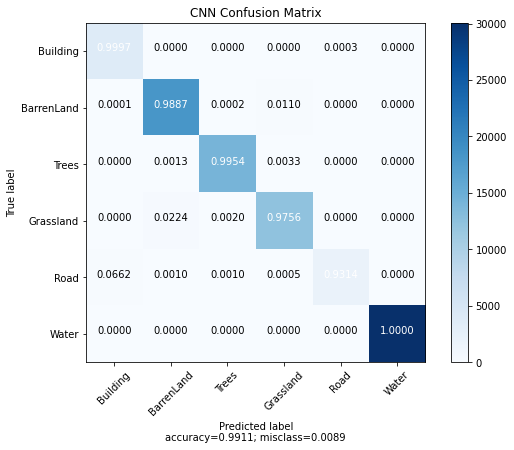

In [25]:
plot_confusion_matrix(
    cm=tf_cm,
    target_names=NAMES,
    title='CNN Confusion Matrix',
    cmap=None,
    normalize=True)

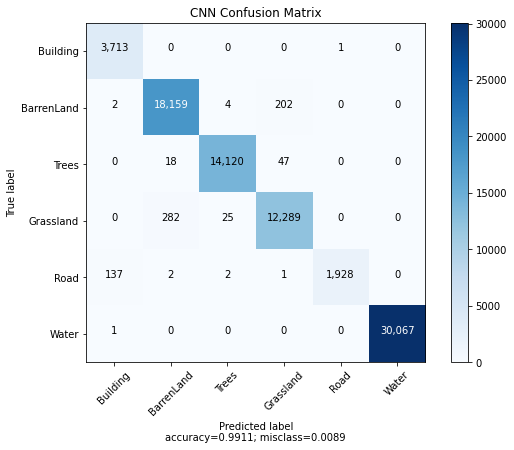

In [26]:
plot_confusion_matrix(
    cm=tf_cm,
    target_names=NAMES,
    title='CNN Confusion Matrix',
    cmap=None,
    normalize=False)

In [31]:
import matplotlib.pyplot as plt
import math
import numpy as np

def plot_histogram(p, axs, list1, my_title='Score Distribution', color='r'):
    # list1 is a tuple where list1[0] is numpy array of bucket and list1[1] is numpy array of frequency
    x_axis = np.array(list1[0])
    bar_width = 1.0 / len(list1[0]) * 0.6
    opacity = 1
    rects1 = axs.bar(list1[0], list1[1], bar_width,
                     alpha=opacity,
                     color=color,
                     label="Distribution")
    p.title(my_title)
    p.xticks(rotation=90)
    p.xticks(x_axis, list(map(lambda v: '{:6.2f}'.format(v), list1[0])))
    axs.ylabel("Percent")
    axs.xlabel("Score")
    # axs.xlabel("Error In %")
    axs.legend()
    
def plot_histogram_wrapper(scores, title, color):
    p_histogram = np.histogram(scores,bins=10) 

    list_p = []
    p_freq = p_histogram[0] / sum(p_histogram[0]) * 100
    list_p.append(p_histogram[1][1:])
    list_p.append(p_freq)

    plot_histogram(plt, plt, list_p, my_title=title, color=color)
    plt.show()


In [29]:
grassland_scores = prob[y_true==3, 3] 
road_scores = prob[y_true==4, 4]


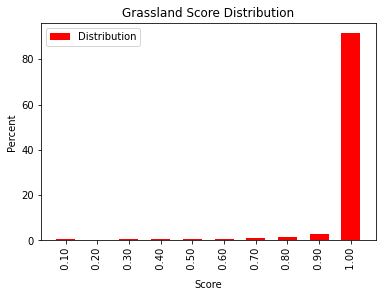

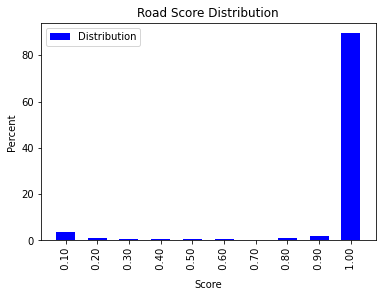

In [32]:
plot_histogram_wrapper(grassland_scores, 'Grassland Score Distribution', 'r')
plot_histogram_wrapper(road_scores, 'Road Score Distribution', 'b')

# CNN + Xgboost

In [14]:
for layer in loaded_model.layers:
    print (layer._name)

input_4
conv1
batch_normalization_4
dropout_2
conv2
batch_normalization_5
conv3
batch_normalization_6
conv4
batch_normalization_7
dropout_3
flatten
fc
main_output


In [15]:
new_output = loaded_model.get_layer('fc').output
new_output.shape

TensorShape([None, 32])

In [16]:
new_model = Model(inputs=loaded_model.input, outputs=new_output)

In [17]:
new_model.predict(x_val[0:1,:,:,:])

array([[ 0.        ,  2.91846   ,  5.6293173 ,  0.        ,  0.        ,
         0.        , 35.065144  ,  0.        ,  0.        , 18.154335  ,
        26.523943  ,  0.        ,  0.11906734, 20.268232  ,  0.        ,
         0.        ,  0.        ,  0.        , 40.901863  ,  0.4471055 ,
         0.        ,  0.        , 18.755348  ,  4.3161387 ,  0.        ,
         0.        , 26.47519   ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [18]:
# Use the output of new_model as input to Xgboost
# Equaivalently we are replacing the softmax regression in the original CNN with an Xgboost



In [19]:
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier


In [30]:
# for demo only. In reality we should consider about potential data leakage introduced by reusing the same training data

xgb_x_train = new_model.predict(x_train)
xgb_x_val = new_model.predict(x_val)

In [31]:
print(xgb_x_train.shape)
print(xgb_x_val.shape)

(100000, 32)
(81000, 32)


In [41]:
xgb_model = XGBClassifier(
    base_score=0.5,
    objective='multi:softprob',
    num_class=6,
    
    gamma=1,
    max_depth=6,
    learning_rate=0.3, 
    min_child_weight=1,
    n_estimators=2000,
    subsample=0.9,
    colsample_bynode=1,
    colsample_bytree=0.9,
    reg_alpha=0,
    reg_lambda=1,

    random_state=0,
    booster='gbtree',
    tree_method='hist',
    seed=1234,
    missing=None,
    verbosity=1
)

print(xgb_model.get_xgb_params())



{'objective': 'multi:softprob', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': 1, 'colsample_bytree': 0.9, 'gamma': 1, 'gpu_id': None, 'interaction_constraints': None, 'learning_rate': 0.3, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 1, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': None, 'subsample': 0.9, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': 1, 'num_class': 6, 'seed': 1234}


In [33]:
xgb_y_train = np.argmax(y_train, axis=1).reshape(-1)
xgb_y_val = np.argmax(y_val, axis=1).reshape(-1)

In [26]:
# xgb_x_train = xgb_x_train.astype(dtype=np.float32)
# xgb_y_train = xgb_y_train.astype(dtype=np.float32)

In [42]:
trained = xgb_model.fit(
    xgb_x_train, xgb_y_train,
    early_stopping_rounds=10,
    # the last metric is used for early stopping
    eval_metric=["merror", "mlogloss"],
    eval_set=[(xgb_x_val, xgb_y_val)], verbose=True)

[0]	validation_0-merror:0.00800	validation_0-mlogloss:1.00617
[1]	validation_0-merror:0.00754	validation_0-mlogloss:0.68733
[2]	validation_0-merror:0.00724	validation_0-mlogloss:0.49090
[3]	validation_0-merror:0.00704	validation_0-mlogloss:0.35880
[4]	validation_0-merror:0.00681	validation_0-mlogloss:0.26619
[5]	validation_0-merror:0.00648	validation_0-mlogloss:0.20026
[6]	validation_0-merror:0.00639	validation_0-mlogloss:0.15254
[7]	validation_0-merror:0.00624	validation_0-mlogloss:0.11782
[8]	validation_0-merror:0.00625	validation_0-mlogloss:0.09247
[9]	validation_0-merror:0.00620	validation_0-mlogloss:0.07385
[10]	validation_0-merror:0.00620	validation_0-mlogloss:0.06006
[11]	validation_0-merror:0.00625	validation_0-mlogloss:0.04993
[12]	validation_0-merror:0.00611	validation_0-mlogloss:0.04238
[13]	validation_0-merror:0.00602	validation_0-mlogloss:0.03673
[14]	validation_0-merror:0.00596	validation_0-mlogloss:0.03246
[15]	validation_0-merror:0.00588	validation_0-mlogloss:0.02935
[1

In [38]:
import pickle
pickle.dump(trained, open('xgb_model', "wb"))

In [46]:
xgb_y_pred = trained.predict(xgb_x_val)

In [59]:
xgb_cm = confusion_matrix(y_true=xgb_y_val, y_pred=xgb_y_pred, labels=CATEGORIES)

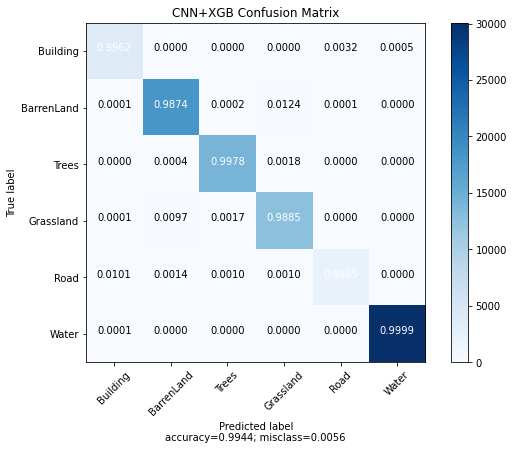

In [60]:
plot_confusion_matrix(
    cm=xgb_cm,
    target_names=NAMES,
    title='CNN+XGB Confusion Matrix',
    cmap=None,
    normalize=True)